In [1]:
import pandas as pd

In [2]:

df = pd.read_excel('BCI backup.xlsx', sheet_name='Dummy leads')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Lead_ID                      20 non-null     object
 1   Booking_ID                   20 non-null     object
 2   Customer name                20 non-null     object
 3   Lead_Source                  20 non-null     object
 4   First_Time_Buyer             20 non-null     object
 5   Age                          20 non-null     int64 
 6   Gender                       20 non-null     object
 7   Location                     20 non-null     object
 8   Income                       20 non-null     int64 
 9   OEM_Loyalty_Program          20 non-null     object
 10  Finances_Status              20 non-null     object
 11  CIBIL_Score                  20 non-null     int64 
 12  Down_Payment                 20 non-null     int64 
 13  Undecided_Finances           20 non-n

In [3]:
df = df.fillna('None')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Lead_ID                      20 non-null     object
 1   Booking_ID                   20 non-null     object
 2   Customer name                20 non-null     object
 3   Lead_Source                  20 non-null     object
 4   First_Time_Buyer             20 non-null     object
 5   Age                          20 non-null     int64 
 6   Gender                       20 non-null     object
 7   Location                     20 non-null     object
 8   Income                       20 non-null     int64 
 9   OEM_Loyalty_Program          20 non-null     object
 10  Finances_Status              20 non-null     object
 11  CIBIL_Score                  20 non-null     int64 
 12  Down_Payment                 20 non-null     int64 
 13  Undecided_Finances           20 non-n

In [4]:
from rules import bci_rules, evaluate_condition

def addTargetValue(row):
    counts = 0
    for i in range(len(bci_rules)):
        if evaluate_condition(row[bci_rules[i]['value']], bci_rules[i]["condition"]):
            counts += 1
    if counts >= 10:
        return 1
    return 0

df['bciindex'] = df.apply(lambda row: addTargetValue(row), axis=1)
print(df['bciindex'].value_counts())
print(df['bciindex'].head())

bciindex
0    15
1     5
Name: count, dtype: int64
0    1
1    0
2    0
3    0
4    0
Name: bciindex, dtype: int64


In [5]:
def checkRows(row):
    row['Booking_Lead_Time'] = int(row['Booking_Lead_Time'].replace(' days', ''))
    row['Add_Ons'] = len(row['Add_Ons'].replace(' ', '').split(';'))
    return row

df = df.apply(checkRows, axis=1)
print(df['Add_Ons'].head())
df_filtered = df.select_dtypes(include=['int64', 'float64', 'datetime64[ns]'])
print(df_filtered.columns)

0    2
1    1
2    1
3    1
4    1
Name: Add_Ons, dtype: int64
Index(['Age', 'Income', 'CIBIL_Score', 'Down_Payment', 'Booking_Lead_Time',
       'Add_Ons', 'Customer_Satisfaction_Score', 'bciindex'],
      dtype='object')


In [6]:
age_labels = ['KID', 'YOUNG', 'OLD']
df['Age'] = pd.cut(df['Age'], bins=3, labels=age_labels)
df['Age'].head()

0      KID
1    YOUNG
2      OLD
3      KID
4      OLD
Name: Age, dtype: category
Categories (3, object): ['KID' < 'YOUNG' < 'OLD']

In [7]:
other_labels = ['LOW', 'MEDIUM', 'HIGH']
df_filtered = df_filtered.drop(['Age', 'bciindex'], axis=1)
for i in df_filtered.columns:
    df[i] = pd.cut(df[i], bins=3, labels=other_labels)
# df[df_filtered.columns] = pd.cut(df[df_filtered.columns], bins=3, labels=other_labels)
df[df_filtered.columns].head()

,Income,CIBIL_Score,Down_Payment,Booking_Lead_Time,Add_Ons,Customer_Satisfaction_Score
0,MEDIUM,MEDIUM,LOW,LOW,HIGH,HIGH
1,HIGH,HIGH,HIGH,MEDIUM,LOW,MEDIUM
2,MEDIUM,LOW,LOW,LOW,LOW,LOW
3,LOW,LOW,LOW,LOW,LOW,HIGH
4,HIGH,HIGH,HIGH,HIGH,LOW,HIGH


In [8]:
df.describe()

,bciindex
count,20.000000
mean,0.250000
std,0.444262
min,0.000000
25%,0.000000
50%,0.000000
75%,0.250000
max,1.000000


In [9]:
# from scipy import stats

# first_time_buyers = df[df['First_Time_Buyer'] == 'Yes']['Customer_Satisfaction_Score']
# repeat_customers = df[df['First_Time_Buyer'] == 'No']['Customer_Satisfaction_Score']

# t_statistic, p_value = stats.ttest_ind(first_time_buyers, repeat_customers)

# print(f"T-statistic: {t_statistic}, P-value: {p_value}")

In [10]:
# Drop Unwanted 
unwanted_columns = ['Lead_ID', 'Booking_ID', 'Customer name', 'Location']
df = df.drop(unwanted_columns, axis=1)


In [11]:
df_filtered = df.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
filtered_columns = [f'C({item})' for item in df_filtered.columns]
logit_formula = 'bciindex ~ ' + ' + '.join(filtered_columns)
print(logit_formula)

bciindex ~ C(Lead_Source) + C(First_Time_Buyer) + C(Age) + C(Gender) + C(Income) + C(OEM_Loyalty_Program) + C(Finances_Status) + C(CIBIL_Score) + C(Down_Payment) + C(Undecided_Finances) + C(Special_Occasions) + C(Booking_Lead_Time) + C(Needs_Match) + C(Add_Ons) + C(Dealership_Engagement) + C(Experience_With_Sales_Rep) + C(Companion_Feedback) + C(Stock_Status) + C(Delivery_Date_Status) + C(Competitive_Factors) + C(External_Factors) + C(Customer_Satisfaction_Score) + C(Cancellation_Probability) + C(Vehicle_Type) + C(Test_Drive_Status) + C(Preferred_Delivery_Time)


In [12]:
import numpy as np
from scipy.stats import chi2_contingency

def cramers_v(confusion_matrix):
    chi2_stat, p_value, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum()
    phi2 = chi2_stat / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))

new_df = df.copy()
new_df[df_filtered.columns] = new_df[df_filtered.columns].apply(lambda x: x.astype('category'))
# sample_df = new_df.sample(frac=0.03, random_state=42)
column_names = df_filtered.columns[2:3]
data = pd.crosstab(new_df['bciindex'], [new_df[col] for col in column_names])
v = cramers_v(data.values)
# print(data.describe())
chi2, p, dof, expected = chi2_contingency(data)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:", expected)

if p < 0.05:
    print("You don't have to remove that features")
else:
    print("You can remove that features" , column_names)

if v > 0.5:
    print('You need to remove features as per Cramer_v as well')

Chi-Square Statistic: 3.4814814814814814
P-value: 0.17539043364728615
Degrees of Freedom: 2
Expected Frequencies: [[6.75 6.   2.25]
 [2.25 2.   0.75]]
You can remove that features Index(['Age'], dtype='object')


In [13]:
# from imblearn.over_sampling import SMOTENC
# categorical_columns = df.drop(['bciindex'], axis=1)
# data_encoded = pd.get_dummies(df, columns=categorical_columns.columns, drop_first=True)
# # corr_matrix = data_encoded.corr()

# X = data_encoded.drop('bciindex', axis=1)
# y = data_encoded['bciindex']

# # List of indices of categorical columns in your dataset
# categorical_features_indices = [i for i, col in enumerate(X.columns) if col in categorical_columns]

# # Apply SMOTENC
# smote = SMOTENC(categorical_features=categorical_features_indices, random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, y)

In [14]:
import statsmodels.api as sm
sm.add_constant(df[df_filtered.columns])
logit_model = sm.Logit.from_formula(logit_formula , df)
# weights = y.apply(lambda x: 1 if x == 1 else 0.5)
fitted_model = logit_model.fit(method='cg', skip_hessian=False)
print(fitted_model.summary())

Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 17
         Function evaluations: 69
         Gradient evaluations: 69
                           Logit Regression Results                           
Dep. Variable:               bciindex   No. Observations:                   20
Model:                          Logit   Df Residuals:                        0
Method:                           MLE   Df Model:                           19
Date:                Tue, 21 Jan 2025   Pseudo R-squ.:                   1.000
Time:                        10:32:25   Log-Likelihood:            -0.00010106
converged:                       True   LL-Null:                       -11.247
Covariance Type:            nonrobust   LLR p-value:                    0.2604
                                               coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------

c:\Users\mukulkathuria\Documents\mlprac\driveai\bciindexanalysis\bcienv\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


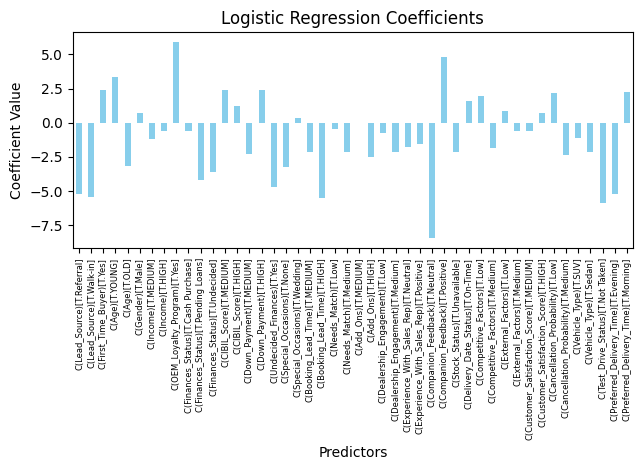

In [15]:
import matplotlib.pyplot as plt
coefficients = fitted_model.params

# Plot the coefficients (excluding intercept)
coefficients.drop('Intercept').plot(kind='bar', color='skyblue')

# Adding titles and labels
plt.title('Logistic Regression Coefficients')
plt.xlabel('Predictors')
plt.ylabel('Coefficient Value')
plt.xticks(fontsize=6)

# Display the plot

plt.tight_layout()  # Adjusts the plot layout to fit everything
# Display the plot
plt.show()

In [32]:
import dalex as dx

X= new_df.drop('bciindex', axis=1)
y = new_df['bciindex']
df_index = pd.read_excel('BCI backup.xlsx', sheet_name='Dummy leads')
exp = dx.Explainer(fitted_model, X, y)

for i in range(len(X)):
    # Get feature importance
    breakdown = exp.predict_parts(X.iloc[i], type='break_down', label=X.index[0])
    breakdown.plot(title=df_index.iloc[i]['Customer name'])
# sh_mary = exp.predict_parts(X.iloc[1], type='shap', B=10, label=X.index[0])

Preparation of a new explainer is initiated

  -> data              : 20 rows 26 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 20 values
  -> model_class       : statsmodels.discrete.discrete_model.BinaryResultsWrapper (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x0000014486D90E00> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 1.3e-18, mean = 0.25, max = 1.0
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -6.44e-06, mean = 3.4e-06, max = 4.63e-05
  -> model_info        : package statsmodels

A new explainer has been created!


c:\Users\mukulkathuria\Documents\mlprac\driveai\bciindexanalysis\bcienv\Lib\site-packages\dalex\_explainer\object.py:138: UserWarning:


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)

